# Proyecto IA

In [8]:
import os
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# Directorios (relativos al lugar donde está este notebook)
DIR_CURVA = os.path.join("curva")
DIR_SELFPLAY = os.path.join("selfplay_qlearning")
DIR_QSTATS = os.path.join("q stats")        # Ojo con el espacio
DIR_MODELOS = os.path.join("q learning")    # Ojo con el espacio

def cargar_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def listar_archivos(directorio, patron="*.json"):
    ruta = os.path.join(directorio, patron)
    archivos = sorted(glob.glob(ruta))
    print(f"{directorio}: {len(archivos)} archivo(s) encontrados.")
    for a in archivos:
        print("  -", os.path.basename(a))
    return archivos


In [10]:
archivos_curva = listar_archivos(DIR_CURVA, "curva_vs_heuristic_medium_*.json")
archivos_selfplay = listar_archivos(DIR_SELFPLAY, "selfplay_qlearning_vs_heuristic_medium_*.json")
archivos_qstats = listar_archivos(DIR_QSTATS, "qstats_completo_*.json")

curva: 3 archivo(s) encontrados.
  - curva_vs_heuristic_medium_20251122_220907.json
  - curva_vs_heuristic_medium_20251122_222054.json
  - curva_vs_heuristic_medium_20251122_224430.json
selfplay_qlearning: 3 archivo(s) encontrados.
  - selfplay_qlearning_vs_heuristic_medium_20251122_220907.json
  - selfplay_qlearning_vs_heuristic_medium_20251122_222054.json
  - selfplay_qlearning_vs_heuristic_medium_20251122_224430.json
q stats: 3 archivo(s) encontrados.
  - qstats_completo_20251122_220907.json
  - qstats_completo_20251122_222054.json
  - qstats_completo_20251122_224430.json


In [16]:
curvas_continuas = []
episodios_acumulados = 0

for path in archivos_curva:
    data = cargar_json(path)
    meta = data["metadata"]

    total_episodios = meta["episodios_totales"]

    # Cada punto del historial tiene:
    # { "episodios": 200, "winrate": ..., ... }
    hist = data["historial"]

    episodios = [p["episodios"] + episodios_acumulados for p in hist]
    winrates = [p["winrate"] for p in hist]

    curvas_continuas.append({
        "episodios": episodios,
        "winrate": winrates,
        "run_id": meta["run_id"],
    })

    # Para el siguiente run, empezamos donde terminamos
    episodios_acumulados += total_episodios


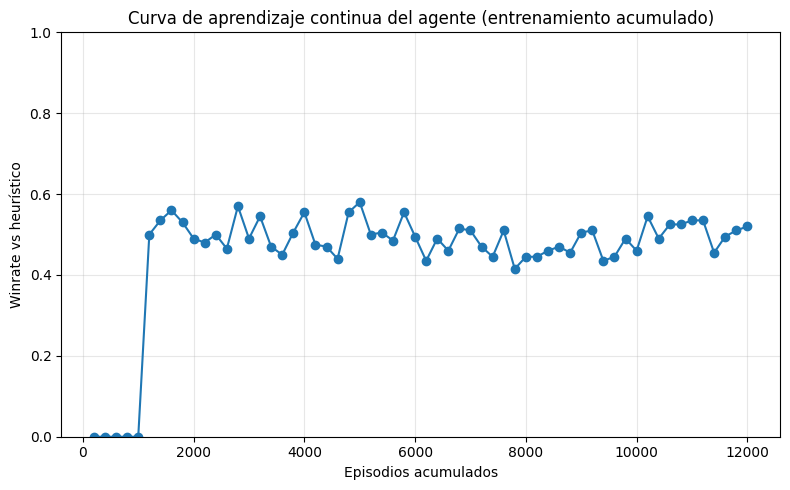

In [20]:
# Construimos una curva totalmente continua (un solo vector de puntos)
episodios_todos = []
winrates_todos = []

episodios_acumulados = 0
for path in archivos_curva:
    data = cargar_json(path)
    meta = data["metadata"]
    total_episodios = meta["episodios_totales"]
    hist = data["historial"]   # lista de dicts

    for p in hist:
        episodios_todos.append(p["episodios"] + episodios_acumulados)
        winrates_todos.append(p["winrate"])

    episodios_acumulados += total_episodios

# Ahora SÓLO UNA LÍNEA
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(episodios_todos, winrates_todos, marker="o")  # sin separar por runs
plt.xlabel("Episodios acumulados")
plt.ylabel("Winrate vs heurístico")
plt.title("Curva de aprendizaje continua del agente (entrenamiento acumulado)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

def media_movil(lista, ventana=5):
    mm = []
    for i in range(len(lista)):
        ini = max(0, i - ventana + 1)
        seg = lista[ini:i+1]
        mm.append(np.mean(seg))
    return mm

def std_movil(lista, ventana=5):
    sm = []
    for i in range(len(lista)):
        ini = max(0, i - ventana + 1)
        seg = lista[ini:i+1]
        sm.append(np.std(seg))
    return sm

# Calcularlas sobre winrates_todos
ventana = 5
mean_curve = media_movil(winrates_todos, ventana=ventana)
std_curve = std_movil(winrates_todos, ventana=ventana)


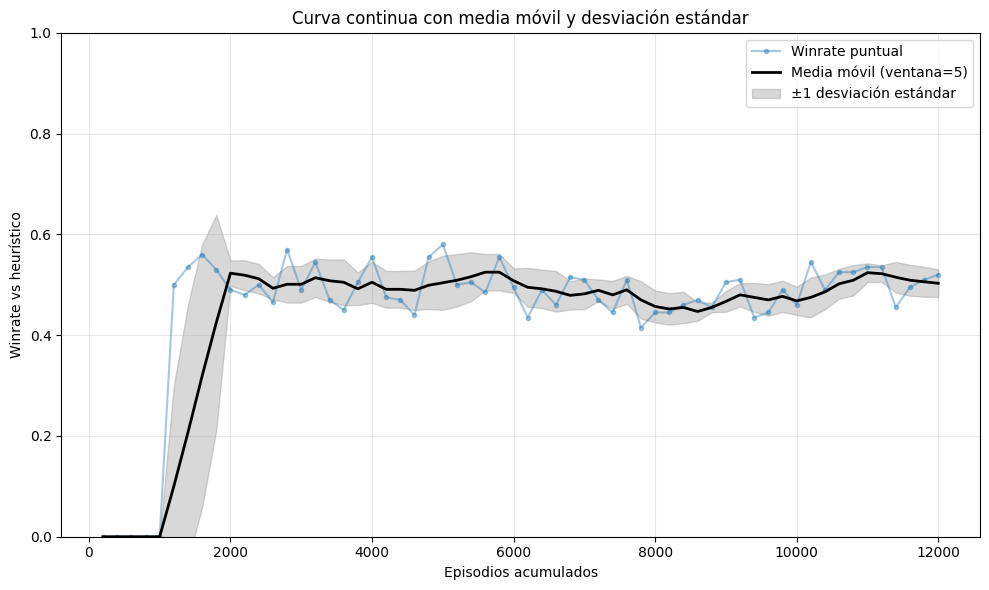

In [22]:
plt.figure(figsize=(10,6))

# Línea original (puntos reales)
plt.plot(episodios_todos, winrates_todos, ".-", alpha=0.4, label="Winrate puntual")

# Media móvil
plt.plot(episodios_todos, mean_curve, color="black", linewidth=2, label=f"Media móvil (ventana={ventana})")

# Banda de ±1 desviación estándar
upper = np.array(mean_curve) + np.array(std_curve)
lower = np.array(mean_curve) - np.array(std_curve)

plt.fill_between(episodios_todos, lower, upper, color="gray", alpha=0.3, label="±1 desviación estándar")

plt.xlabel("Episodios acumulados")
plt.ylabel("Winrate vs heurístico")
plt.title("Curva continua con media móvil y desviación estándar")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
episodios_sp_todos = []
recompensas_todas = []
longitudes_todas = []

episodios_acum = 0

for path in archivos_selfplay:
    data = cargar_json(path)
    meta = data["metadata"]
    total_epis = meta["episodios_totales"]

    eps = data["episodios"]
    rs  = data["recompensas"]
    Ls  = data["longitudes"]

    for ep, r, L in zip(eps, rs, Ls):
        episodios_sp_todos.append(ep + episodios_acum)
        recompensas_todas.append(r)
        longitudes_todas.append(L)

    episodios_acum += total_epis

len(episodios_sp_todos), len(recompensas_todas), len(longitudes_todas)


(12000, 12000, 12000)

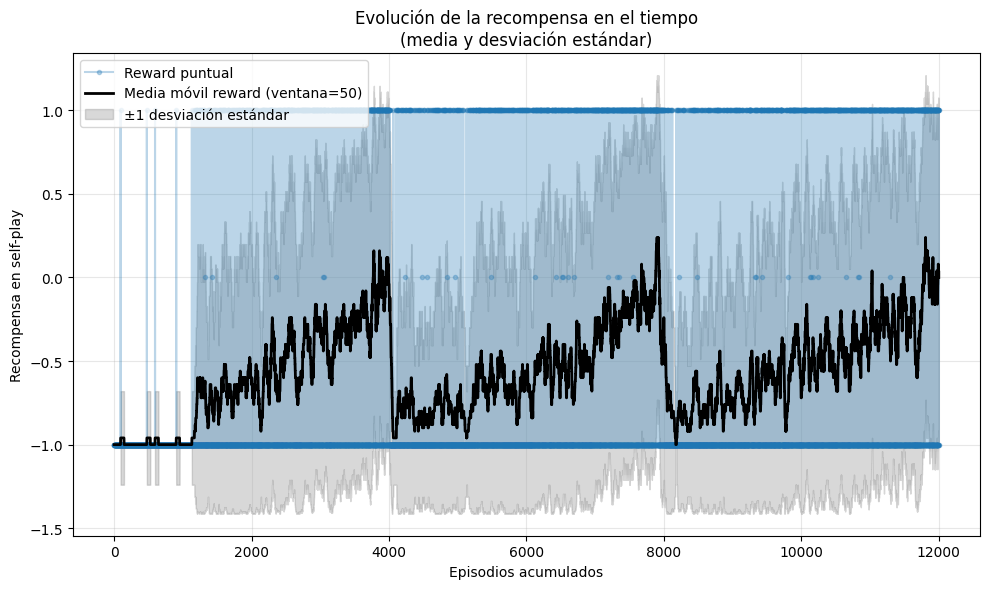

In [25]:
ventana = 50  # puedes ajustar

reward_mean = media_movil(recompensas_todas, ventana=ventana)
reward_std  = std_movil(recompensas_todas, ventana=ventana)

upper_r = np.array(reward_mean) + np.array(reward_std)
lower_r = np.array(reward_mean) - np.array(reward_std)

plt.figure(figsize=(10,6))

plt.plot(episodios_sp_todos, recompensas_todas, ".-", alpha=0.3, label="Reward puntual")
plt.plot(episodios_sp_todos, reward_mean, color="black", linewidth=2,
         label=f"Media móvil reward (ventana={ventana})")
plt.fill_between(episodios_sp_todos, lower_r, upper_r,
                 alpha=0.3, color="gray", label="±1 desviación estándar")

plt.xlabel("Episodios acumulados")
plt.ylabel("Recompensa en self-play")
plt.title("Evolución de la recompensa en el tiempo\n(media y desviación estándar)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


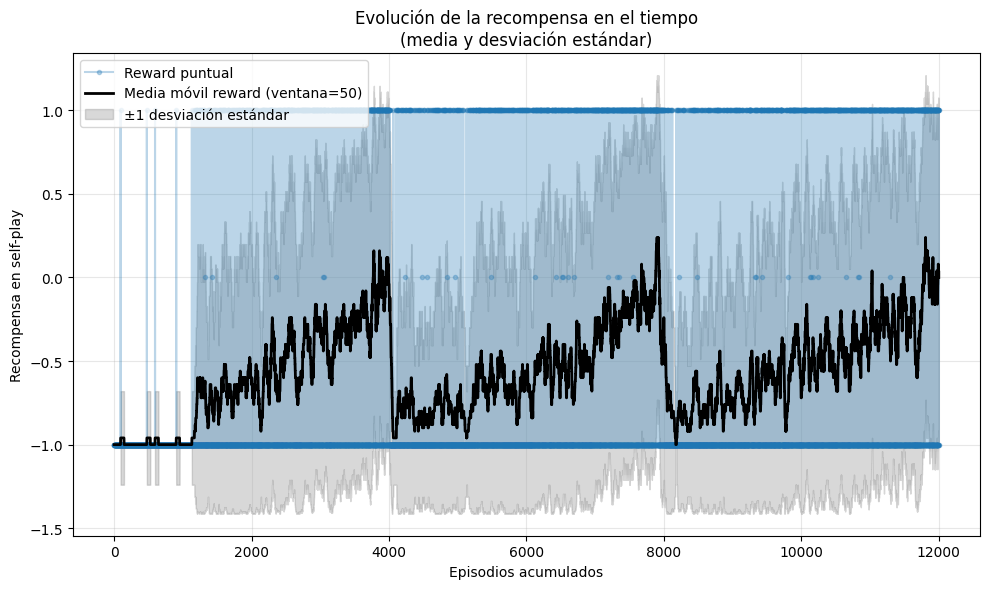

In [26]:
ventana = 50  # puedes ajustar

reward_mean = media_movil(recompensas_todas, ventana=ventana)
reward_std  = std_movil(recompensas_todas, ventana=ventana)

upper_r = np.array(reward_mean) + np.array(reward_std)
lower_r = np.array(reward_mean) - np.array(reward_std)

plt.figure(figsize=(10,6))

plt.plot(episodios_sp_todos, recompensas_todas, ".-", alpha=0.3, label="Reward puntual")
plt.plot(episodios_sp_todos, reward_mean, color="black", linewidth=2,
         label=f"Media móvil reward (ventana={ventana})")
plt.fill_between(episodios_sp_todos, lower_r, upper_r,
                 alpha=0.3, color="gray", label="±1 desviación estándar")

plt.xlabel("Episodios acumulados")
plt.ylabel("Recompensa en self-play")
plt.title("Evolución de la recompensa en el tiempo\n(media y desviación estándar)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


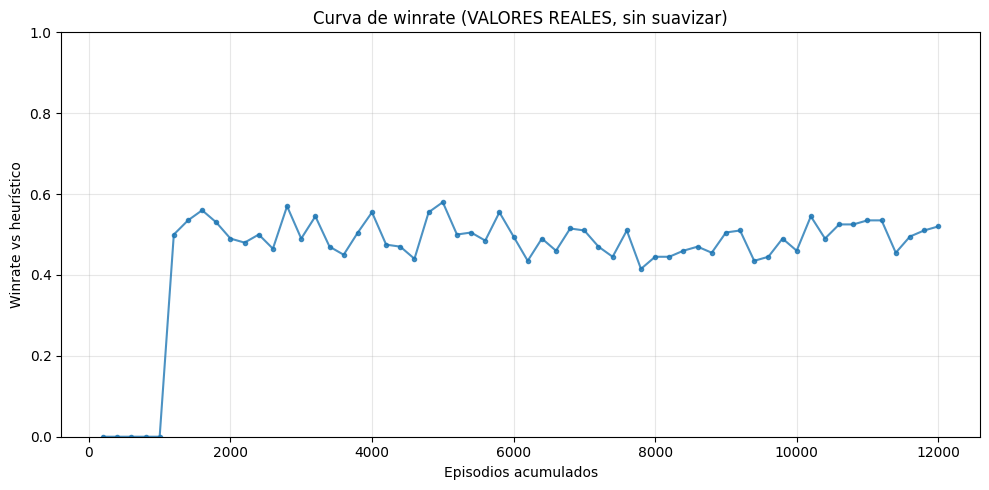

In [27]:
plt.figure(figsize=(10,5))
plt.plot(episodios_todos, winrates_todos, ".-", alpha=0.8, label="Winrate puntual")

plt.xlabel("Episodios acumulados")
plt.ylabel("Winrate vs heurístico")
plt.title("Curva de winrate (VALORES REALES, sin suavizar)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


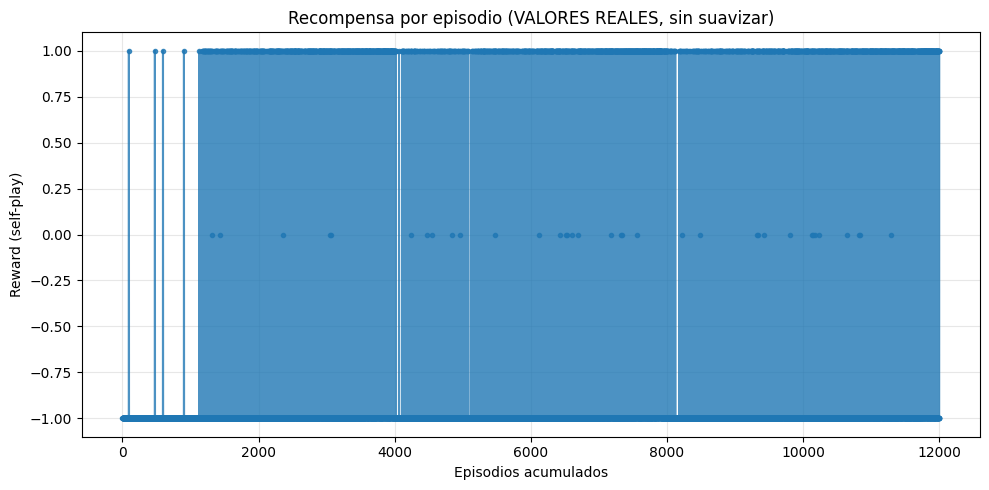

In [28]:
plt.figure(figsize=(10,5))
plt.plot(episodios_sp_todos, recompensas_todas, ".-", alpha=0.8, label="Reward puntual")

plt.xlabel("Episodios acumulados")
plt.ylabel("Reward (self-play)")
plt.title("Recompensa por episodio (VALORES REALES, sin suavizar)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


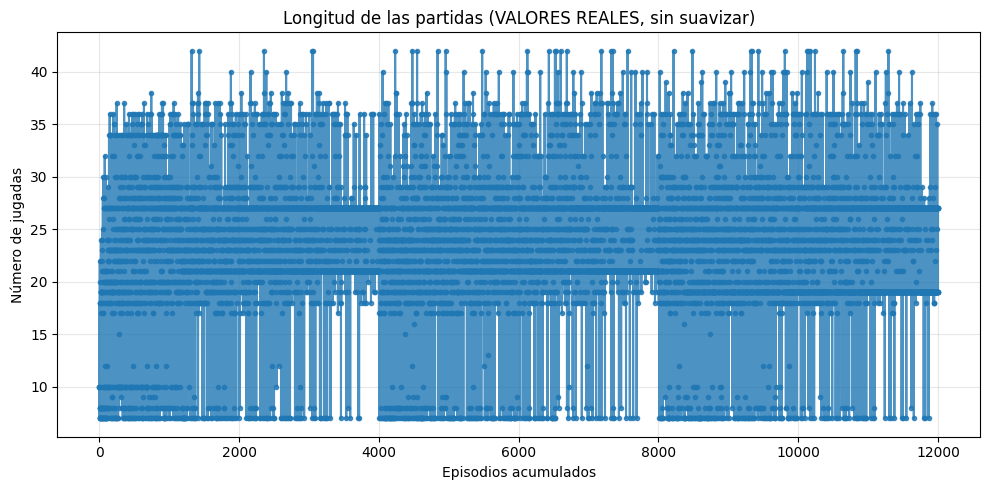

In [29]:
plt.figure(figsize=(10,5))
plt.plot(episodios_sp_todos, longitudes_todas, ".-", alpha=0.8, label="Longitud puntual")

plt.xlabel("Episodios acumulados")
plt.ylabel("Número de jugadas")
plt.title("Longitud de las partidas (VALORES REALES, sin suavizar)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
